In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Configure matplotlib
sns.set(style="whitegrid")
%matplotlib inline

In [3]:
df = pd.read_csv('/content/Dry_Eye_Dataset.csv')


In [4]:
# Displaying basic info about the dataset
print("Dataset Info:\n", df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       20000 non-null  object 
 1   Age                          20000 non-null  int64  
 2   Sleep duration               20000 non-null  float64
 3   Sleep quality                20000 non-null  int64  
 4   Stress level                 20000 non-null  int64  
 5   Blood pressure               20000 non-null  object 
 6   Heart rate                   20000 non-null  int64  
 7   Daily steps                  20000 non-null  int64  
 8   Physical activity            20000 non-null  int64  
 9   Height                       20000 non-null  int64  
 10  Weight                       20000 non-null  int64  
 11  Sleep disorder               20000 non-null  object 
 12  Wake up during night         20000 non-null  object 
 13  Feel sleepy duri

In [5]:
# Encode target variable
df['Dry Eye Disease'] = df['Dry Eye Disease'].map({'Y': 1, 'N': 0})

# Handle categorical features
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('Blood pressure')
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Split blood pressure
bp = df['Blood pressure'].str.split('/', expand=True).astype(float)
df['Systolic BP'] = bp[0]
df['Diastolic BP'] = bp[1]
df.drop(columns='Blood pressure', inplace=True)

# Identify numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('Dry Eye Disease')

# Handle missing values
imputer = SimpleImputer(strategy='mean')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Scale numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Train-test split
X = df.drop(columns='Dry Eye Disease')
y = df['Dry Eye Disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:05:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [7]:
# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

# Evaluate all models
evaluate_model("SVM", y_test, svm_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



Model: SVM
Accuracy: 0.7015
Confusion Matrix:
 [[ 292 1015]
 [ 179 2514]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.22      0.33      1307
           1       0.71      0.93      0.81      2693

    accuracy                           0.70      4000
   macro avg       0.67      0.58      0.57      4000
weighted avg       0.68      0.70      0.65      4000


Model: Random Forest
Accuracy: 0.6965
Confusion Matrix:
 [[ 280 1027]
 [ 187 2506]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.21      0.32      1307
           1       0.71      0.93      0.81      2693

    accuracy                           0.70      4000
   macro avg       0.65      0.57      0.56      4000
weighted avg       0.67      0.70      0.65      4000


Model: XGBoost
Accuracy: 0.651
Confusion Matrix:
 [[ 343  964]
 [ 432 2261]]
Classification Report:
               precision    recall  f

In [8]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Train LightGBM
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train_sm, y_train_sm)
lgb_preds = lgb_model.predict(X_test)

# Evaluate
evaluate_model("LightGBM (with SMOTE)", y_test, lgb_preds)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10344, number of negative: 10344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 20688, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Model: LightGBM (with SMOTE)
Accuracy: 0.69875
Confusion Matrix:
 [[ 294 1013]
 [ 192 2501]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.22      0.33      1307
           1       0.71      0.93      0.81      2693

    accuracy                           0.70      4000
   macro avg       0.66      0.58      0.57      4000
weighted avg       0.68      0.70      0.65      4000



In [9]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('lgb', LGBMClassifier(random_state=42))
], voting='soft')

# Fit on SMOTE-balanced data
ensemble.fit(X_train_sm, y_train_sm)
ensemble_preds = ensemble.predict(X_test)

# Evaluate
evaluate_model("Voting Classifier (SVM + RF + LGBM)", y_test, ensemble_preds)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10344, number of negative: 10344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 20688, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Model: Voting Classifier (SVM + RF + LGBM)
Accuracy: 0.69075
Confusion Matrix:
 [[ 325  982]
 [ 255 2438]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.25      0.34      1307
           1       0.71      0.91      0.80      2693

    accuracy                           0.69      4000
   macro avg       0.64      0.58      0.57      4000
weighted avg       0.66      0.69      0.65      4000



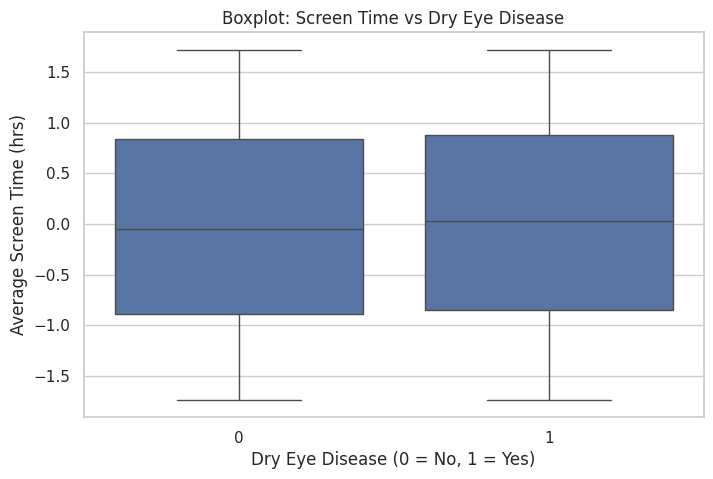

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Dry Eye Disease', y='Average screen time', data=df)
plt.title('Boxplot: Screen Time vs Dry Eye Disease')
plt.xlabel('Dry Eye Disease (0 = No, 1 = Yes)')
plt.ylabel('Average Screen Time (hrs)')
plt.show()


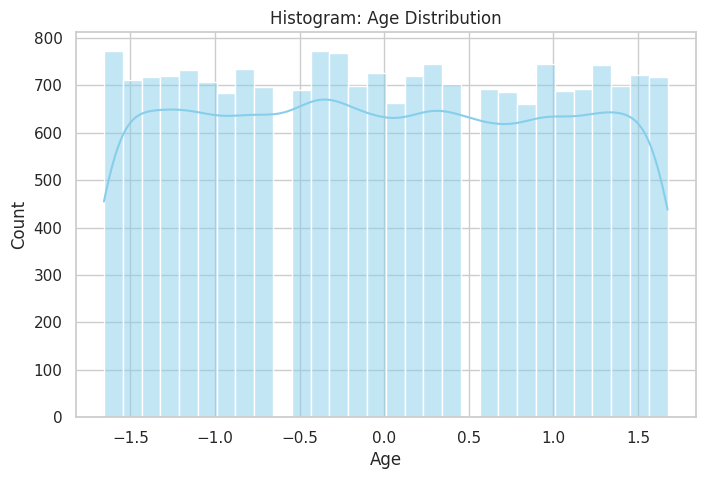

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df['Age'], bins=30, kde=True, color='skyblue')
plt.title('Histogram: Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


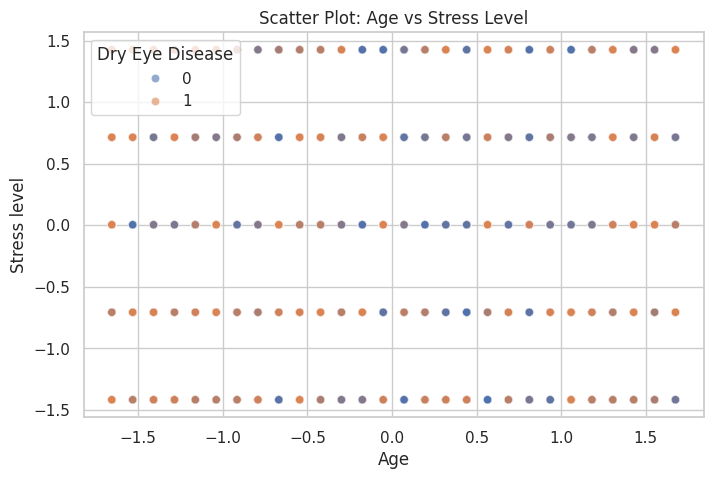

In [12]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Age', y='Stress level', hue='Dry Eye Disease', data=df, alpha=0.6)
plt.title('Scatter Plot: Age vs Stress Level')
plt.show()


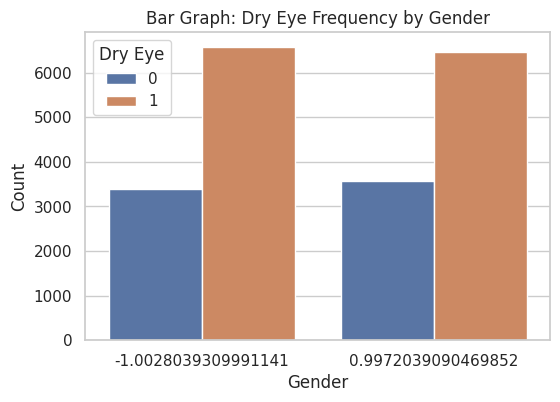

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x='Gender', hue='Dry Eye Disease', data=df)
plt.title('Bar Graph: Dry Eye Frequency by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Dry Eye')
plt.show()


<ipython-input-14-c1011b779279>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_time['Time'] = pd.date_range(start='2023-01-01', periods=len(df), freq='H')


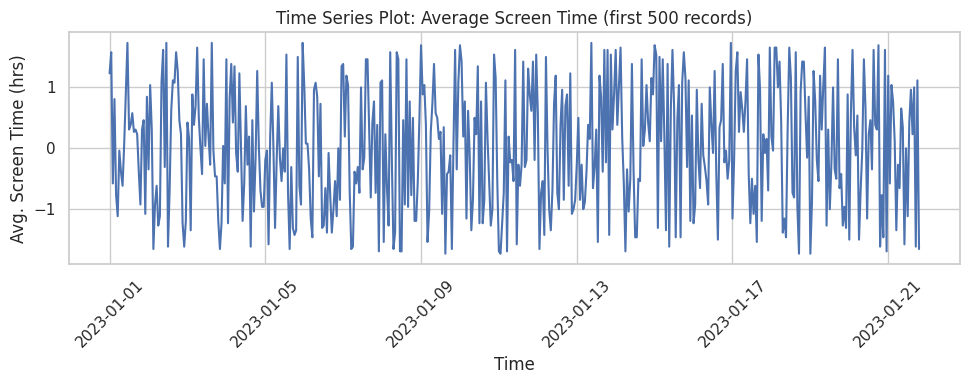

In [14]:
df_time = df.copy()
df_time['Time'] = pd.date_range(start='2023-01-01', periods=len(df), freq='H')

plt.figure(figsize=(10,4))
sns.lineplot(x='Time', y='Average screen time', data=df_time[:500])
plt.title('Time Series Plot: Average Screen Time (first 500 records)')
plt.xlabel('Time')
plt.ylabel('Avg. Screen Time (hrs)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import confusion_matrix

# Example: LightGBM confusion matrix
cm = confusion_matrix(y_test, lgb_preds)
tn, fp, fn, tp = cm.ravel()

print(f"Confusion Matrix:\n{cm}")
print(f"\nType I Error (False Positive): {fp}")
print(f"Type II Error (False Negative): {fn}")


Confusion Matrix:
[[ 294 1013]
 [ 192 2501]]

Type I Error (False Positive): 1013
Type II Error (False Negative): 192


In [16]:
from scipy.stats import chi2_contingency

# Example: Gender vs Dry Eye Disease
contingency_table = pd.crosstab(df['Gender'], df['Dry Eye Disease'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test for Gender vs Dry Eye Disease")
print(f"Chi2 = {chi2:.4f}, p-value = {p:.4f}")


Chi-Square Test for Gender vs Dry Eye Disease
Chi2 = 5.2594, p-value = 0.0218


In [17]:
from statsmodels.stats.proportion import proportions_ztest

# Test if the proportion of class 1 is significantly higher than class 0
count = np.array([sum(y==1), sum(y==0)])
nobs = np.array([len(y), len(y)])

z_stat, p_val = proportions_ztest(count, nobs)
print(f"Z-test statistic = {z_stat:.4f}")
print(f"p-value = {p_val:.4f}")


Z-test statistic = 60.7400
p-value = 0.0000


In [18]:
from scipy.stats import f

# Choose two numeric columns
x1 = df['Average screen time']
x2 = df['Stress level']

# Compute F-statistic
f_stat = np.var(x1, ddof=1) / np.var(x2, ddof=1)
df1 = len(x1) - 1
df2 = len(x2) - 1
p_value = 1 - f.cdf(f_stat, df1, df2)

print("F-Test: Variance Comparison (Screen Time vs Stress Level)")
print(f"F = {f_stat:.4f}, p = {p_value:.4f}")


F-Test: Variance Comparison (Screen Time vs Stress Level)
F = 1.0000, p = 0.5000
